In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sns
sns.set_theme(style="darkgrid")
import re
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [17]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
print(df.isna().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [4]:
df.dropna(axis=0, how='any',inplace=True)

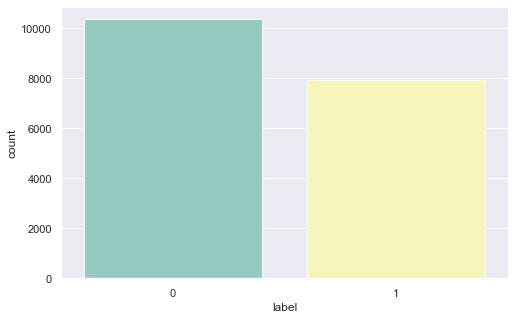

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df, palette='Set3')
plt.show()

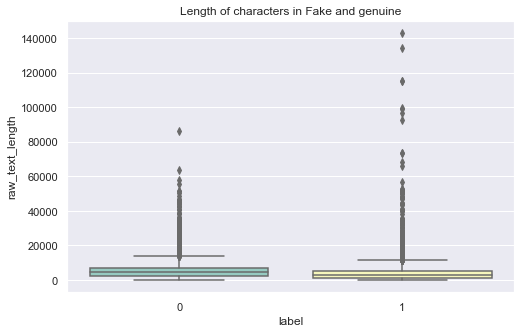

In [13]:
# lets look at the article length
plt.figure(figsize=(8,5))
df['raw_text_length'] = df['text'].apply(lambda x: len(x))
sns.boxplot(y='raw_text_length', x='label', data=df, palette='Set3')
plt.title('Length of characters in Fake and genuine')
plt.show()

In [14]:
df['text'] = df['text'].str.strip()
# Recalculate the length
df['raw_text_length'] = df['text'].apply(lambda x: len(x))
print(len(df[df['raw_text_length']==0]))

74


##### the total number of zero-length texts is 74.


In [15]:
df = pd.read_csv('train.csv')
df = df.fillna(' ')
df['text'] = df['text'].str.strip()
df['raw_text_length'] = df['text'].apply(lambda x: len(x))
print(len(df[df['raw_text_length']==0]))
print(df.isna().sum())
df = df[df['raw_text_length'] > 0]
print(df.shape)
print(df.isna().sum())

74
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64
(18211, 6)
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64


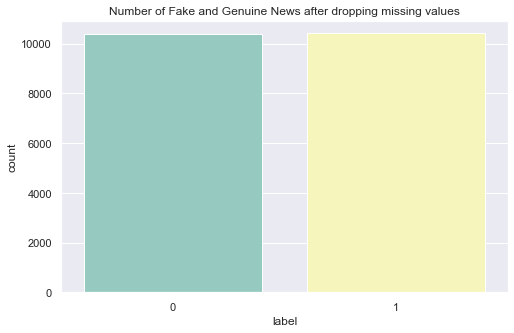

In [18]:
# Visualize the target's distribution\
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df, palette='Set3')
plt.title("Number of Fake and Genuine News after dropping missing values")
plt.show()

## Text Preprocessing

In [19]:
gen_news_authors = set(list(df[df['label']==0]['author'].unique()))
fake_news_authors = set(list(df[df['label']==1]['author'].unique()))
overlapped_authors = gen_news_authors.intersection(fake_news_authors)
print("Number of distinct authors with genuine articles: {}", len(gen_news_authors))
print("Number of distinct authors with fake articles: {}", len(fake_news_authors))
print("Number of distinct authors with both genuine and fake: {}", len(overlapped_authors))

Number of distinct authors with genuine articles: {} 2226
Number of distinct authors with fake articles: {} 1982
Number of distinct authors with both genuine and fake: {} 6


In [21]:
overlapped_authors

{'AFP', 'Ann Coulter', 'Pam Key', 'Pamela Geller', 'Reuters', nan}

In [33]:
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
    print(cleaned_text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)

In [34]:
preprocess_text("I've a car...")

I've a car
I've a car...
I've a car...
I've a car...


''

In [82]:
# text_cols = ['text', 'title', 'author']
# for col in text_cols:
#     print("Processing column: {}".format(col))
#     df[col] = df[col].apply(lambda x: preprocess_text(x))

##### Once, this is done, the regular word tokenization is done followed by stopword removal.

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [55]:
nltk.stopwords()

AttributeError: module 'nltk' has no attribute 'stopwords'

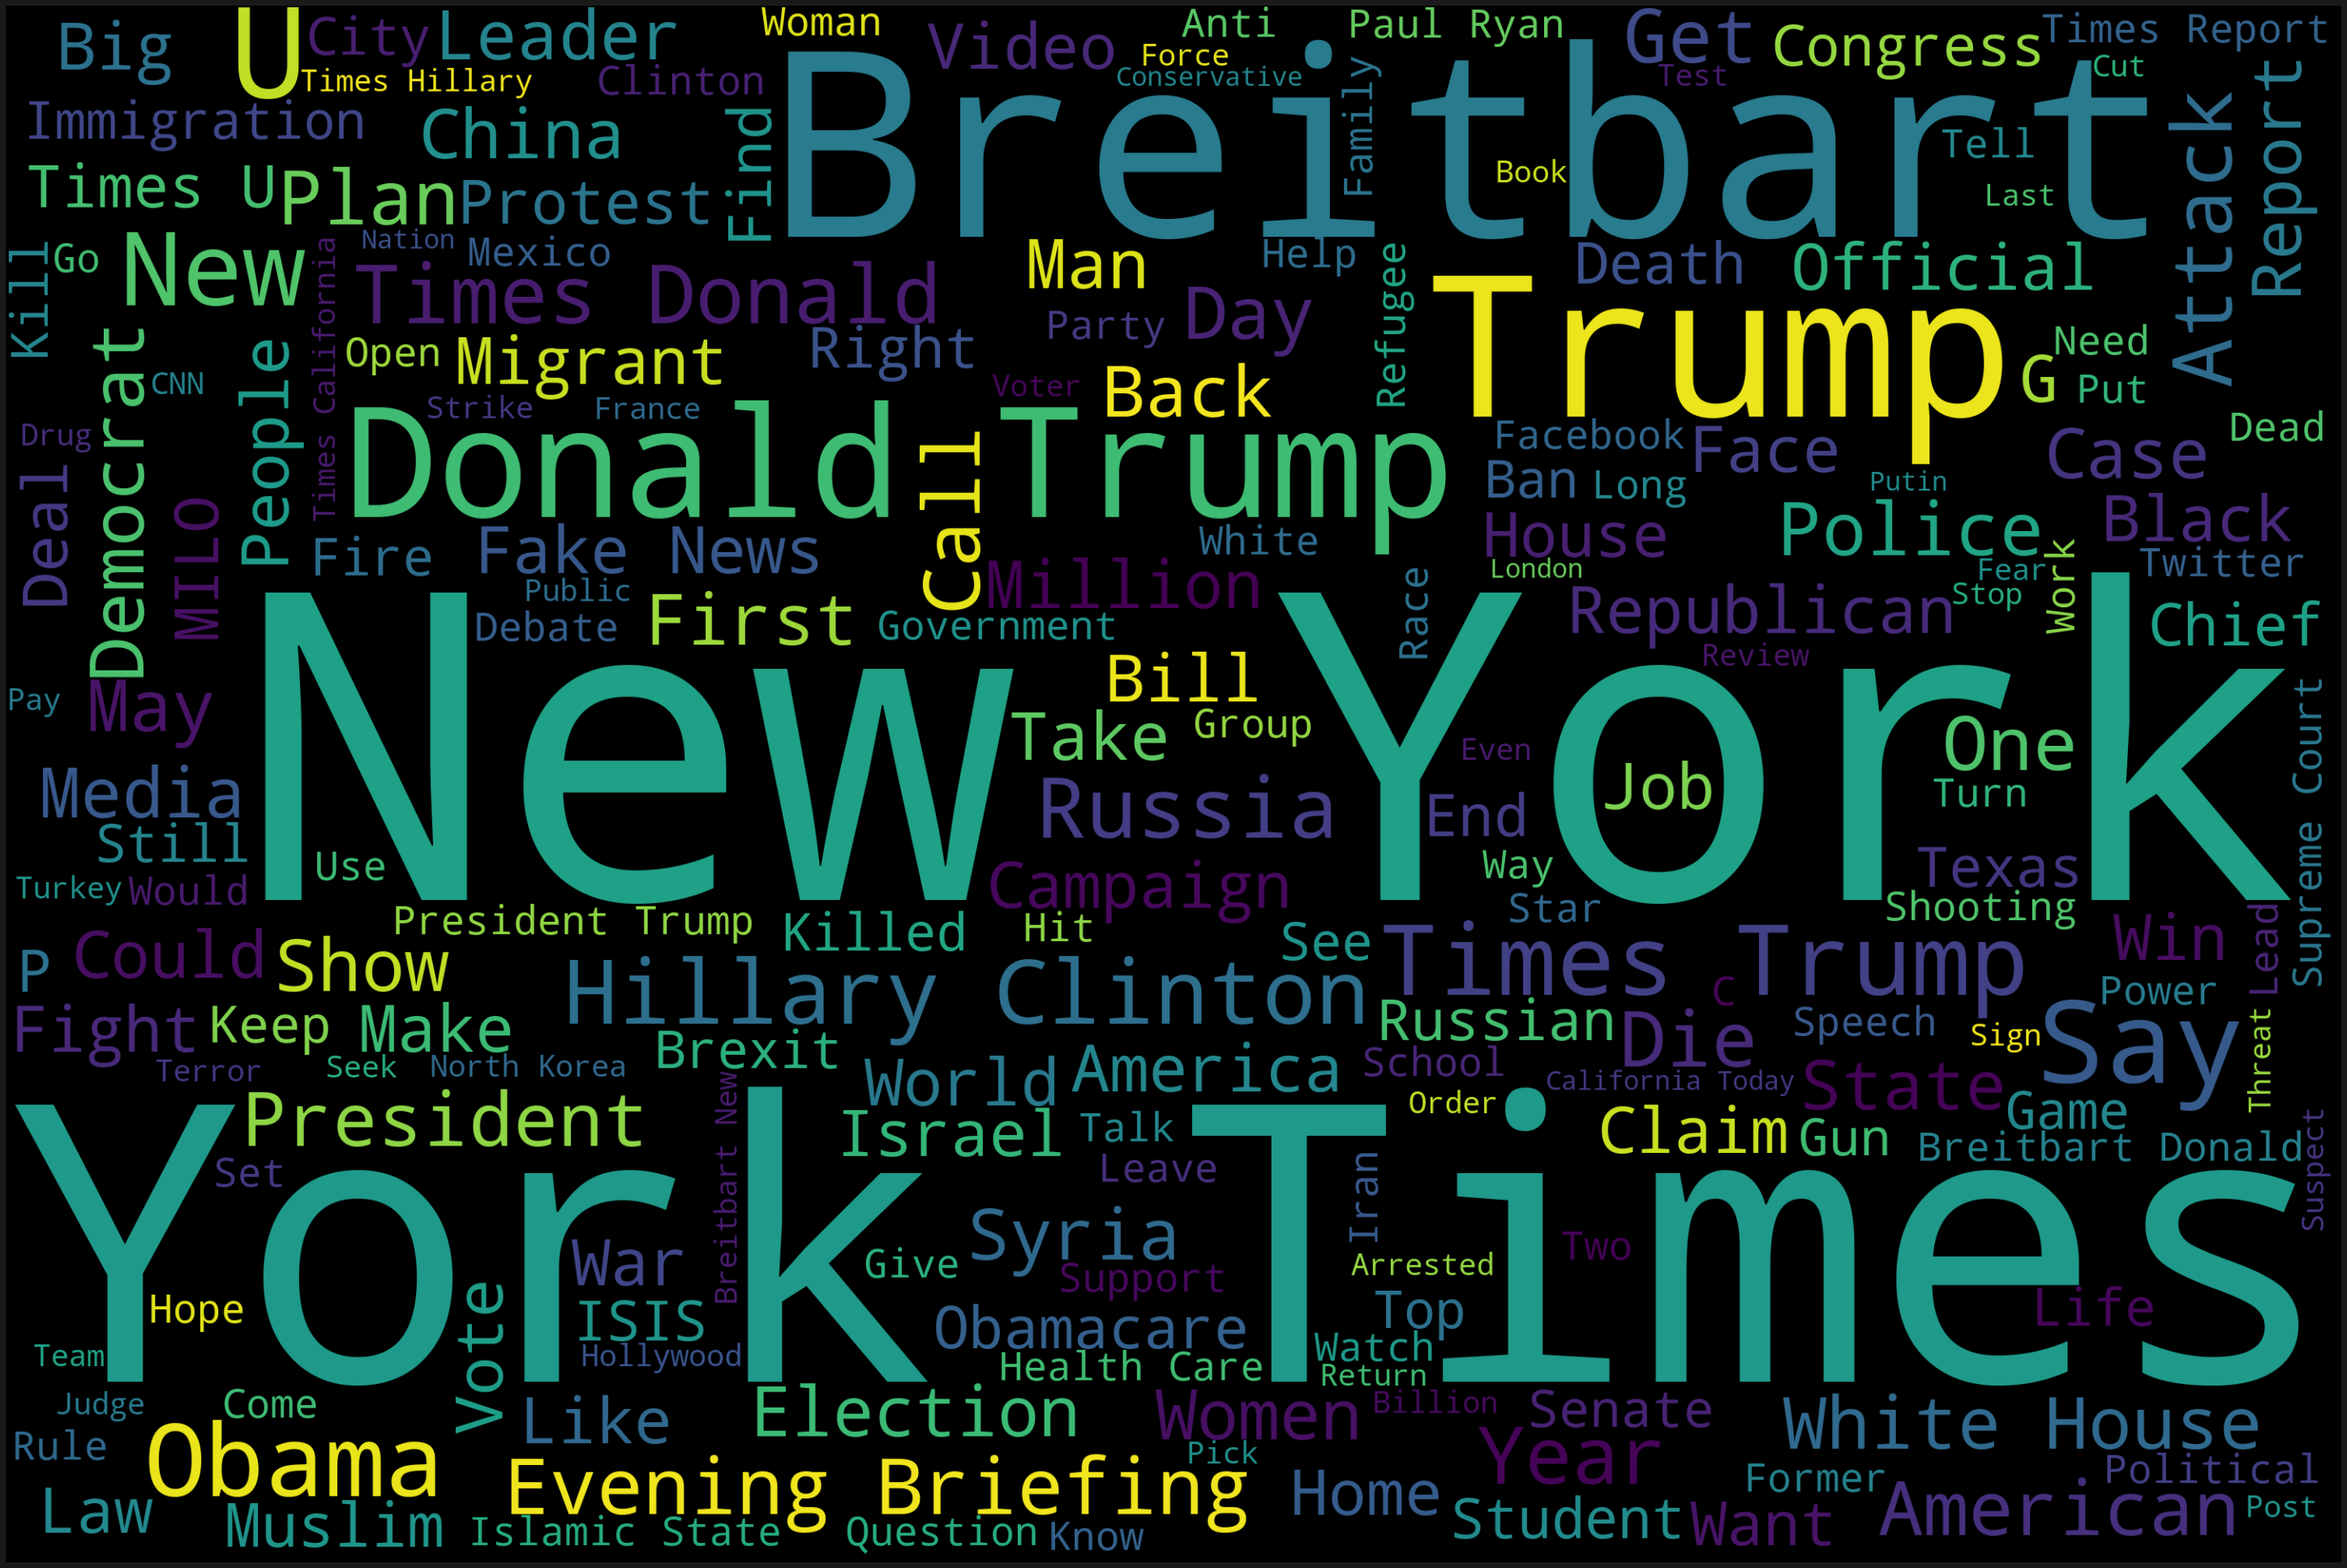

In [46]:
# Preparing the word cloud for the real news article to order to understand type of words in real news
# (column : title of the news)

real = df[df['label']==0]
real.shape


text = ''
for news in real.title.values:
    text += f" {news}"  # f will help to retain the text as a string
wordcloud = WordCloud(width = 3000,height = 2000, background_color = 'black',
                      stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# In this real news articles there is mention of publisher : (eg : Newyork times) in some articles

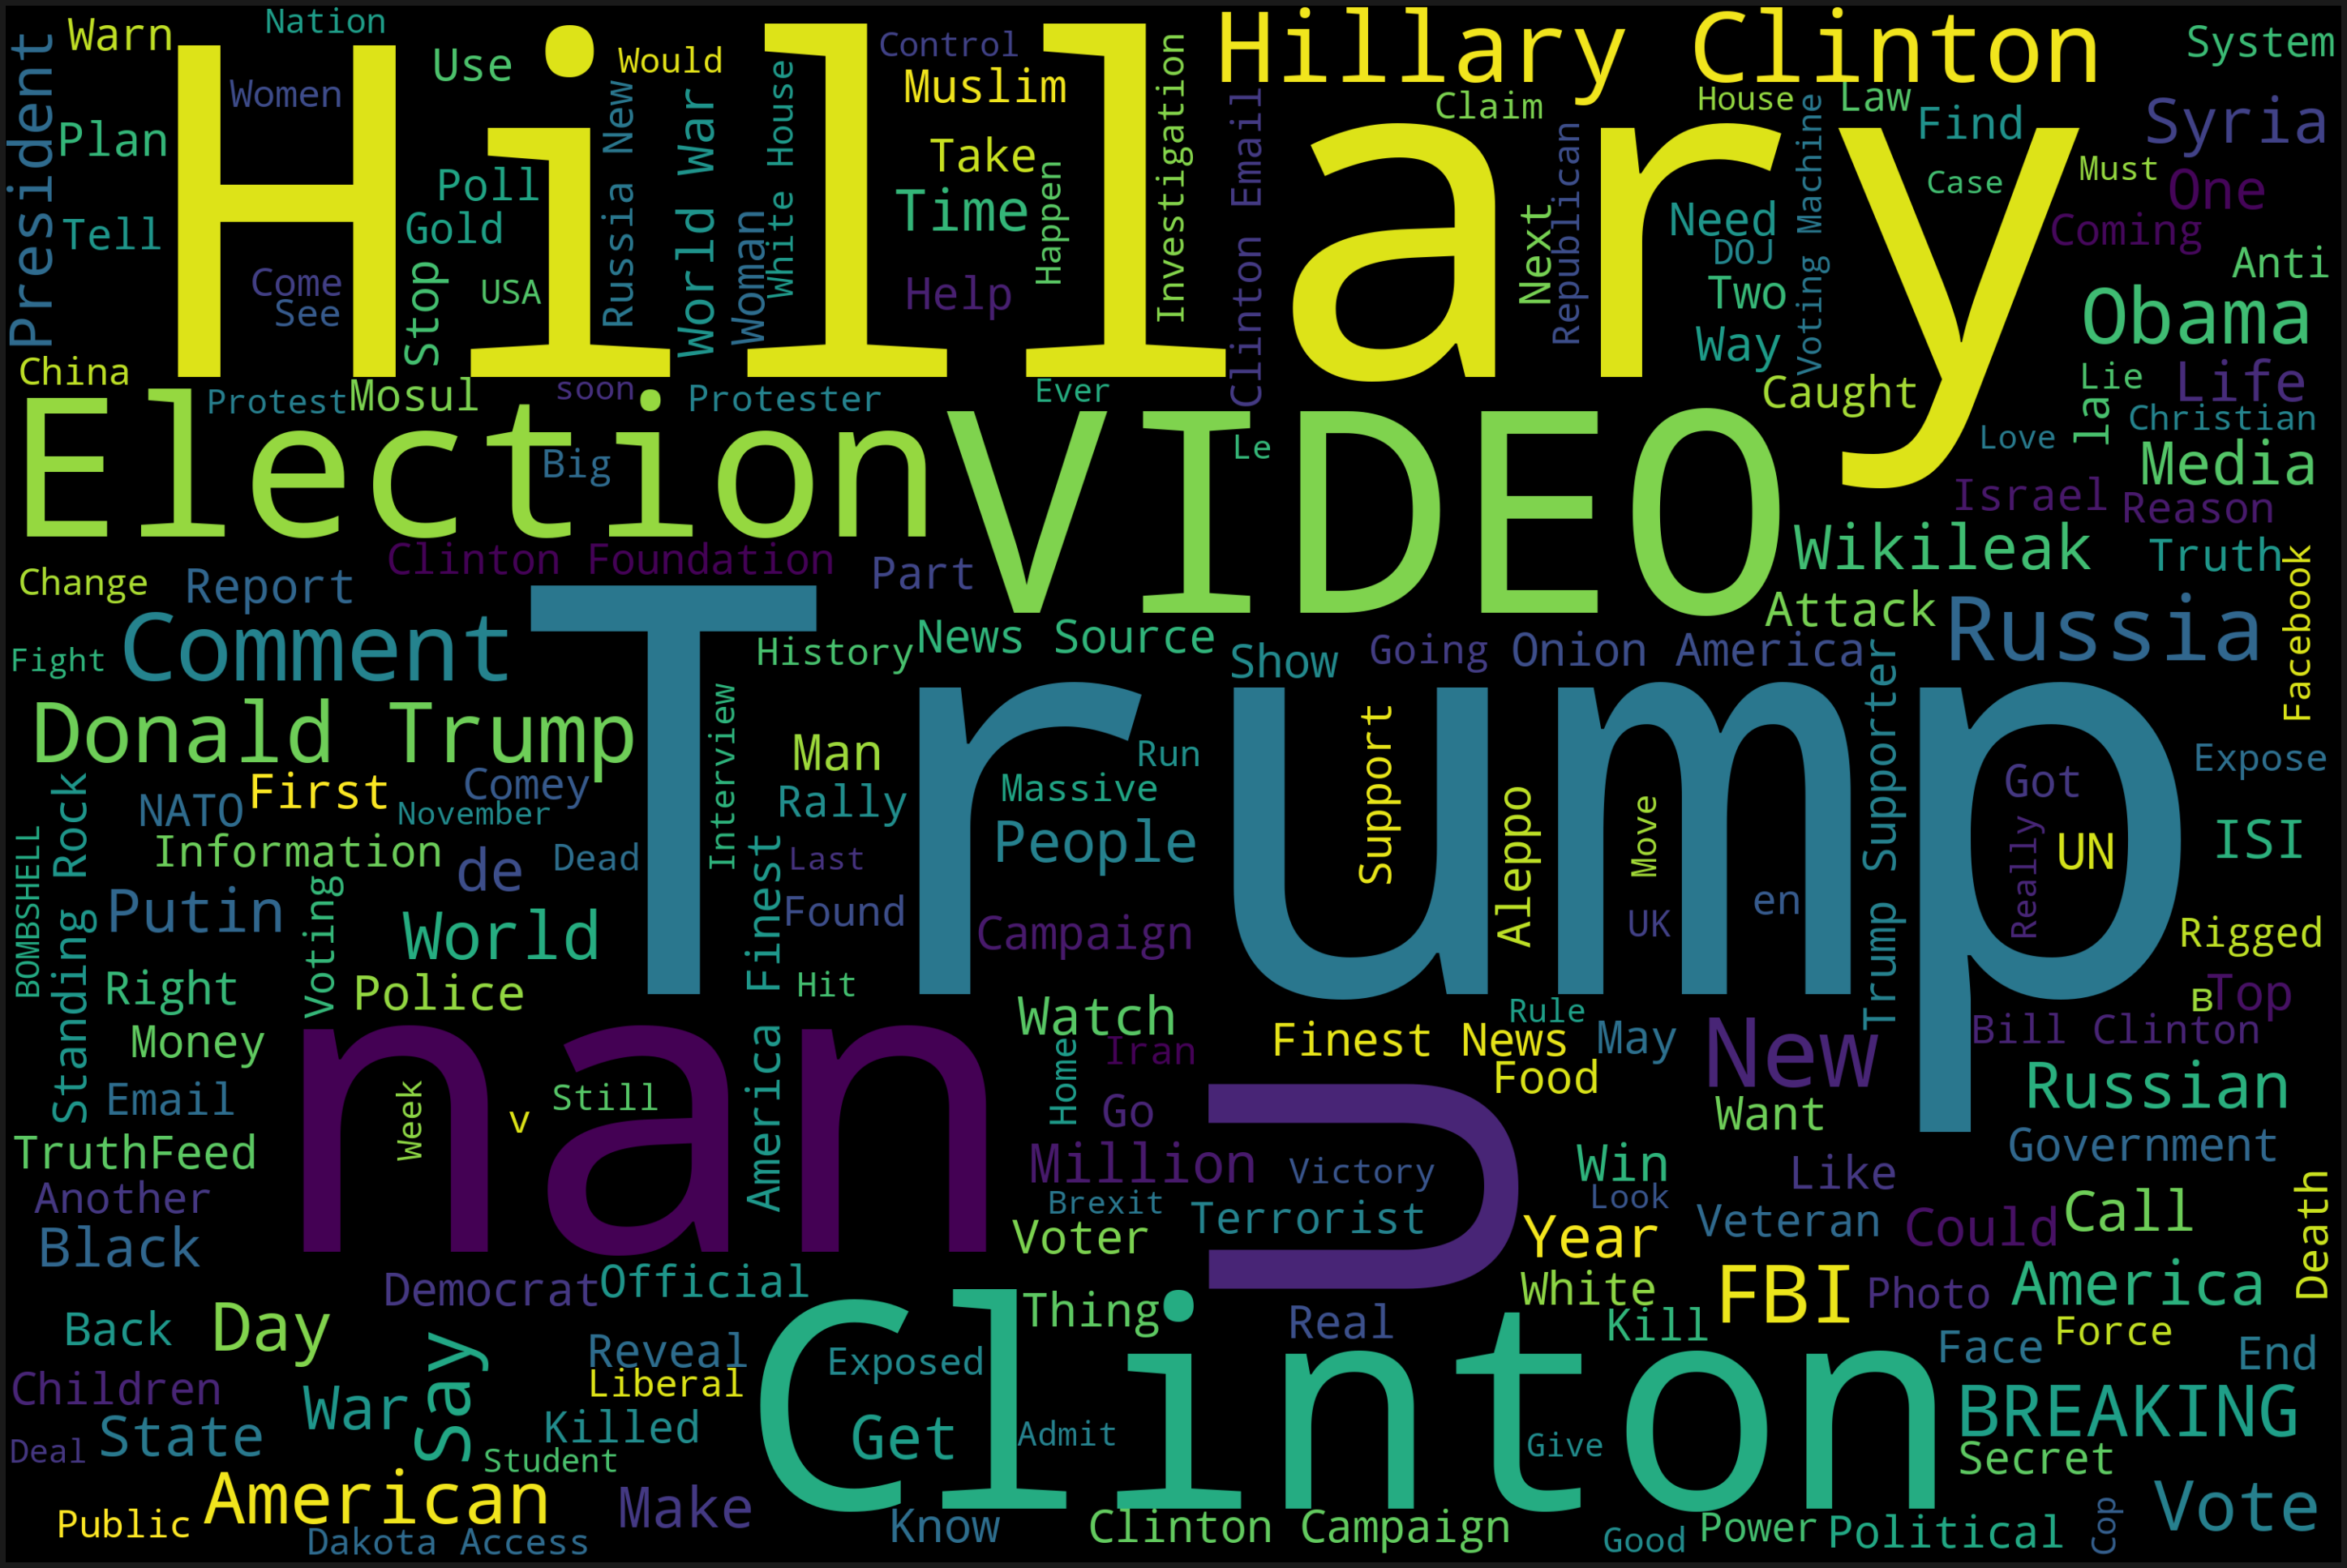

In [47]:
# Preparing the word cloud for fake news article to order to understand type of words in fake news
# (column : title)

fake = df[df['label']==1]
fake.shape

text = ''
for news in fake.title.values:
    text += f" {news}"  # f will help to retain the text as a string
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# In this articles there is no mention of any publisher in the fake news 

In [48]:
# Creating a new independent variable  : concatenating author and title column
# This new independent variable (creating using author and title column) would be perform better in classifying the real and fake news instead of taking an individual variable
# Will use this new independent variable in building the model

df['ti_auth'] = df['title']+' '+ df['author']

In [50]:
X = df.drop(['label'],axis=1)
print(X.shape)

Y = df['label']
print(Y.head())

(20800, 5)
0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64


## Text Preprocessing
Steps as below :

1.Removing special characters and numbers

2.Converting into lowercase to develop a consistent data

3.Tokenize the text, ignoring stopwords and performing stemming on the words

In [51]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [58]:
stopwords = nltk.corpus.stopwords.words("english")

In [60]:
stopwords = set(stopwords)

In [63]:
# Training data

corpus_train=[]

for i in range(len(X)):
    input = re.sub('[^a-zA-Z]',' ',str(X['ti_auth'][i])) # except a-z and A-Z, substitute all other characters with ' '
    input = input.lower() # Lower case 
    input  = input.split() # tokenize the text
    input = [ps.stem(word) for word in input if word not in stopwords] # ignoring stopwords and stemming rest of the words
    text = ' '.join(input)  # concatenating all words into a single text (list is created)#
    corpus_train.append(text) # appending text into a single corpus #
len(corpus_train)

20800

In [64]:
X['ti_auth'][5]

'Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart Daniel Nussbaum'

In [66]:
corpus_train[:3]

['hous dem aid even see comey letter jason chaffetz tweet darrel lucu',
 'flynn hillari clinton big woman campu breitbart daniel j flynn',
 'truth might get fire consortiumnew com']

### Building the word embedding layer with help of keras embedding

In [72]:
# Converting this text into One hot representation #
# Provide an index for each and every word in the text w.r.t the voc_size

voc_size =5000
onehot_rep_train = [one_hot(words,voc_size)for words in corpus_train]

In [73]:
onehot_rep_train[0]

[1084, 1187, 4071, 4970, 4701, 3921, 230, 1494, 4121, 1627, 368, 2846]

In [76]:
# Train dataset #
# Find out the maximum length of the sentence in the corpus so that we will pad all sentences to that length

c=[]
for i in range(len(df)):
    m=len(str(df['ti_auth'][i]).split())
    c.append(m)

print('Maximum length of a sentence is : ',max(c))
print('Average length of a sentence is : ',sum(c)/len(c))

# In train dataset, max length is 74

Maximum length of a sentence is :  74
Average length of a sentence is :  13.24875


In [77]:
# Pad_sequences in order to make all sentences of equal lenghts of 74

embedded_docs_train = pad_sequences(onehot_rep_train,padding='pre',maxlen=74)
embedded_docs_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1084, 1187, 4071, 4970,
       4701, 3921,  230, 1494, 4121, 1627,  368, 2846])

## Building the LSTM Model

In [78]:
from sklearn.metrics import classification_report, accuracy_score

In [79]:
# Building an LSTM Model with an embedding layer #
model = Sequential()
model.add(Embedding(voc_size,40,input_length=74))  # 40 : dimension of each vector, input_length : sentence length
model.add(Dropout(0.3))
model.add(LSTM(100))  # 100 memory cells / Neurons 
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 74, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 74, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [80]:
#Converting into numpy array
train_final = np.array(embedded_docs_train)
y_final = np.array(Y)

In [81]:
#training model
model.fit(train_final,y_final,epochs=5,batch_size=100)

Epoch 1/5
208/208 [==============================] - 33s 130ms/step - loss: 0.3779 - accuracy: 0.8193
Epoch 2/5
208/208 [==============================] - 27s 128ms/step - loss: 0.0296 - accuracy: 0.9930
Epoch 3/5
208/208 [==============================] - 25s 122ms/step - loss: 0.0171 - accuracy: 0.9967
Epoch 4/5
208/208 [==============================] - 20s 96ms/step - loss: 0.0143 - accuracy: 0.9975
Epoch 5/5
208/208 [==============================] - 27s 130ms/step - loss: 0.0106 - accuracy: 0.9980


## Building the Bi-LSTM Model

In [83]:
# Building an LSTM Model with an embedding layer #
model1 = Sequential()
model1.add(Embedding(voc_size,40,input_length=74))  # 40 : dimension of each vector, input_length : sentence length
model1.add(Dropout(0.3))
model1.add(Bidirectional(LSTM(100)))  # 100 memory cells / Neurons 
model1.add(Dropout(0.3))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))  # sigmoid will help in classifying news as fake or real
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 74, 40)            200000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
# training model
model1.fit(train_final,y_final,epochs=10,batch_size=100)

Epoch 1/10
208/208 [==============================] - 52s 210ms/step - loss: 0.3522 - accuracy: 0.8391
Epoch 2/10
208/208 [==============================] - 48s 229ms/step - loss: 0.0281 - accuracy: 0.9930
Epoch 3/10
208/208 [==============================] - 41s 196ms/step - loss: 0.0154 - accuracy: 0.9976
Epoch 4/10
208/208 [==============================] - 41s 199ms/step - loss: 0.0107 - accuracy: 0.9979
Epoch 5/10
208/208 [==============================] - 42s 204ms/step - loss: 0.0093 - accuracy: 0.9984
Epoch 6/10
208/208 [==============================] - 44s 212ms/step - loss: 0.0092 - accuracy: 0.9984
Epoch 7/10
208/208 [==============================] - 44s 210ms/step - loss: 0.0102 - accuracy: 0.9983
Epoch 8/10
208/208 [==============================] - 44s 212ms/step - loss: 0.0076 - accuracy: 0.9987
Epoch 9/10
208/208 [==============================] - 44s 211ms/step - loss: 0.0111 - accuracy: 0.9980
Epoch 10/10
206/208 [============================>.] - ETA: 0s - loss: 0.